<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Demo_optimize_dual_polarization_hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are continously working to optimize repository size and structure. 

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 3102, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 3102 (delta 47), reused 83 (delta 30), pack-reused 2977
Receiving objects: 100% (3102/3102), 766.57 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (1104/1104), done.
Updating files: 100% (357/357), done.
Filtering content: 100% (19/19), 77.20 MiB | 14.49 MiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creat

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597245 sha256=85bb2b5225d508825ccc89f3cf3d2c2f5a3f37f9cf6b1da074e0474a64049625
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12


# Optimize a metasurface to produce independent hologram for x and y polarization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import dflat.datasets_image as df_images
import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_opt
import dflat.plot_utilities as df_plot
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural


Similar to other examples, I will utilize the optimization helper packaged in DFlat to avoid writing boiler-plate SGD optimization code. We inherit the DFlat Pipeline_Object and optimize it with the run_pipeline_optimization function

In [ ]:
class generate_hologram_metasurface(df_opt.Pipeline_Object):
    def __init__(self, target_int, prop_params, savepath, saveAtEpochs):
        super(generate_hologram_metasurface, self).__init__(savepath, saveAtEpochs)

        # Initialize the compuational pipeline
        self.target_int = tf.convert_to_tensor(target_int / np.sum(target_int, axis=(1, 2), keepdims=True), dtype=tf.float64)
        self.propagation_parameters = prop_params
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer("MLP_Nanofins_Dense512_U350_H600")
        self.propagator = df_fourier.Propagate_Planes_Layer(prop_params)

        # initialize trainable lens
        ms_samplesM = prop_params["ms_samplesM"]
        init_latent_tensor = tf.zeros((2, ms_samplesM["y"], ms_samplesM["x"]), dtype=tf.float64)
        self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor")

    def __call__(self):
        # propagate field to output plane
        wavelength_set_m = self.propagation_parameters["wavelength_set_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, wavelength_set_m)
        norm = tf.math.reduce_sum(out[0][0] ** 2, axis=(1, 2), keepdims=True)

        field_ampl, _ = self.propagator(out)
        field_int = field_ampl**2 / norm

        # Add the field int to class attribute
        self.field_int = field_int

        # Compute the L1 loss of target vs realized hologram intensity
        error = tf.math.reduce_sum(tf.math.abs(field_int - self.target_int))

        return error

    def visualizeTrainingCheckpoint(self, epoch_str):
        fig = plt.figure(figsize=(10,10))
        ax = df_plot.addAxis(fig, 2, 2)

        ax[0].imshow(self.field_int[0, 0])
        ax[0].set_title("x-Polarized light")
        
        ax[1].imshow(self.field_int[0, 1])
        ax[1].set_title("y-Polarized light")
        
        ax[2].imshow(self.target_int[0])
        ax[2].set_title("Target Hologram x")
        
        ax[3].imshow(self.target_int[1])
        ax[3].set_title("Target Hologram y")
        #plt.savefig(self.savepath + "/trainingOutput/png_images/checkpoint_img_" + epoch_str + ".png")
        plt.show()
        return



 OVERVIEW OF PARAMETERS 


 wavelength_m 5.32e-07

 ms_length_m:  {'x': 0.000512, 'y': 0.000512}

 ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_ms_dx_m:  {'x': 9.980506822612085e-07, 'y': 9.980506822612085e-07}

 ms_samplesM:  {'x': 512, 'y': 512, 'r': 256}

 calc_samplesM:  {'x': 513, 'y': 513, 'r': 257}

 calc_samplesN:  {'x': 751, 'y': 751, 'r': 376}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 9.980506822612085e-07, 'y': 9.980506822612085e-07}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 750, 'y': 750}


Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanofins_Dense512_U350_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanofins_Dense512_U350_H600


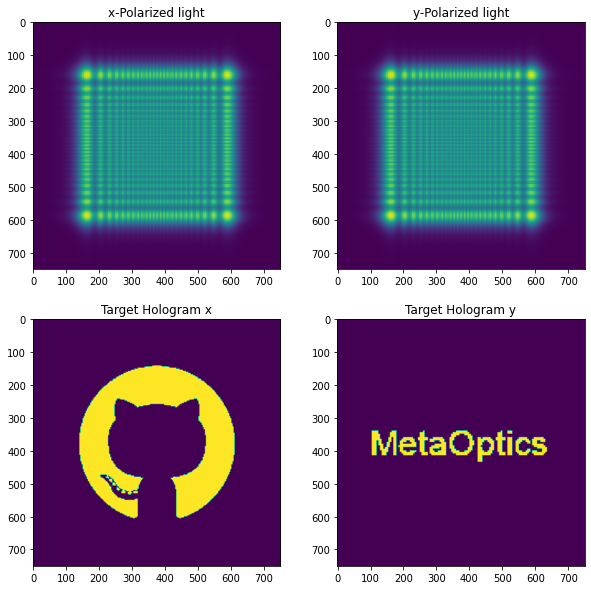

Training Log | (Step, time, loss):  0 1.3371245861053467 3.081365054836822
Training Log | (Step, time, loss):  1 1.0413877964019775 2.8217291125103974
Training Log | (Step, time, loss):  2 1.0216023921966553 2.5887049427270243
Training Log | (Step, time, loss):  3 1.0380964279174805 2.3444658693256963
Training Log | (Step, time, loss):  4 1.027449131011963 2.1166758244926647
Training Log | (Step, time, loss):  5 1.036177396774292 1.8981274513454378
Training Log | (Step, time, loss):  6 1.0152950286865234 1.7189288128760931
Training Log | (Step, time, loss):  7 1.0206096172332764 1.5806745522740646
Training Log | (Step, time, loss):  8 1.0190939903259277 1.4793744956778152
Training Log | (Step, time, loss):  9 1.0303981304168701 1.4018712967740272
Log Training at step: 10


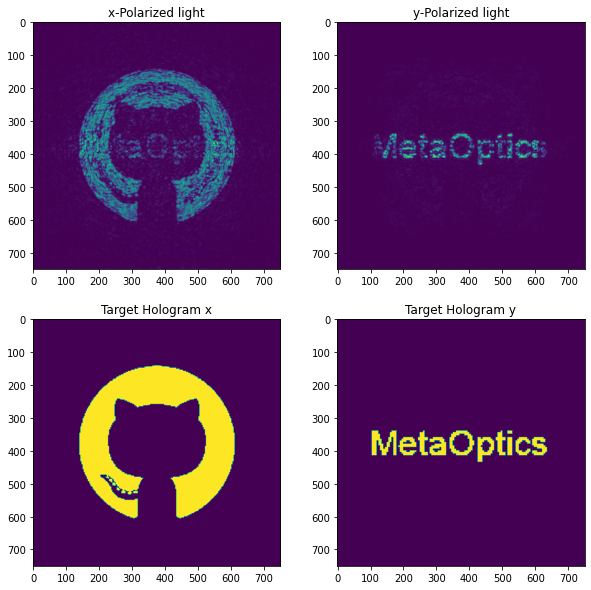

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  10 1.03139066696167 1.3401834190130975
Training Log | (Step, time, loss):  11 1.0255591869354248 1.2882197079162683
Training Log | (Step, time, loss):  12 1.025909662246704 1.2433088988220689
Training Log | (Step, time, loss):  13 1.0225121974945068 1.20264207962482
Training Log | (Step, time, loss):  14 1.0477263927459717 1.1650848637200142
Training Log | (Step, time, loss):  15 1.0412006378173828 1.1315464112219784
Training Log | (Step, time, loss):  16 1.0419442653656006 1.1010327082582483
Training Log | (Step, time, loss):  17 1.0469717979431152 1.0732965450265295
Training Log | (Step, time, loss):  18 1.0432074069976807 1.0486699164501603
Training Log | (Step, time, loss):  19 1.031421184539795 1.026460361536835
Log Training at step: 20


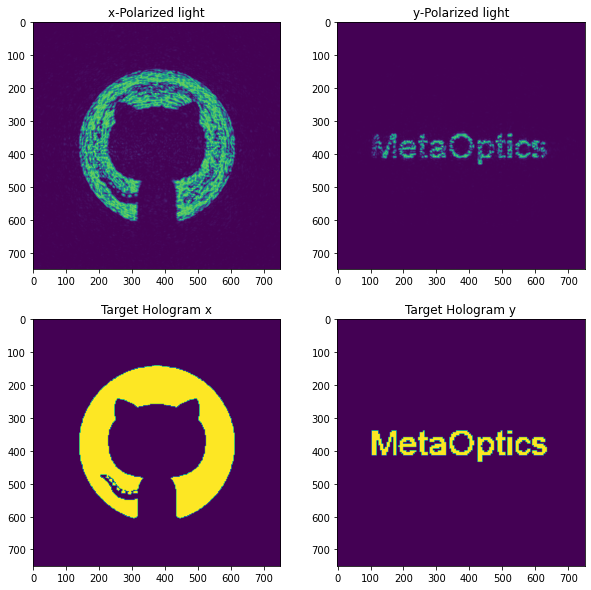

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  20 1.0397989749908447 1.0062569811277415
Training Log | (Step, time, loss):  21 1.0345473289489746 0.9881312624440185
Training Log | (Step, time, loss):  22 1.0389957427978516 0.9713470239444554
Training Log | (Step, time, loss):  23 1.0357069969177246 0.9555747633996647
Training Log | (Step, time, loss):  24 1.041881799697876 0.9407234615439696
Training Log | (Step, time, loss):  25 1.0384531021118164 0.9267101776222034
Training Log | (Step, time, loss):  26 1.0538256168365479 0.9133807267272517
Training Log | (Step, time, loss):  27 1.0642659664154053 0.9011713641558114
Training Log | (Step, time, loss):  28 1.0505270957946777 0.8899409319437752
Training Log | (Step, time, loss):  29 1.0612914562225342 0.87912893860728
Log Training at step: 30


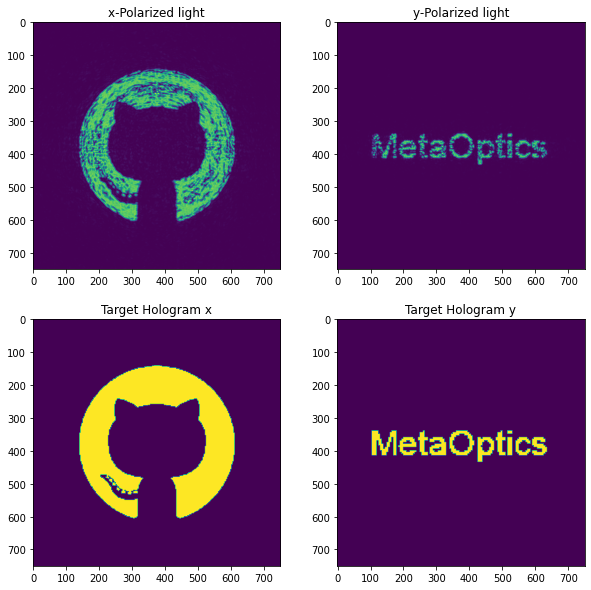

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  30 1.0742926597595215 0.8692945096199652
Training Log | (Step, time, loss):  31 1.043675184249878 0.8598475383883092
Training Log | (Step, time, loss):  32 1.045274019241333 0.8513630855495117
Training Log | (Step, time, loss):  33 1.0492758750915527 0.8431841772665463
Training Log | (Step, time, loss):  34 1.0413703918457031 0.8358043443764778
Training Log | (Step, time, loss):  35 1.0436890125274658 0.8287517010251527
Training Log | (Step, time, loss):  36 1.0361568927764893 0.822009794801288
Training Log | (Step, time, loss):  37 1.0386097431182861 0.8157988022820544
Training Log | (Step, time, loss):  38 1.0379292964935303 0.8097961862159894
Training Log | (Step, time, loss):  39 1.0511314868927002 0.8042652198971698
Log Training at step: 40


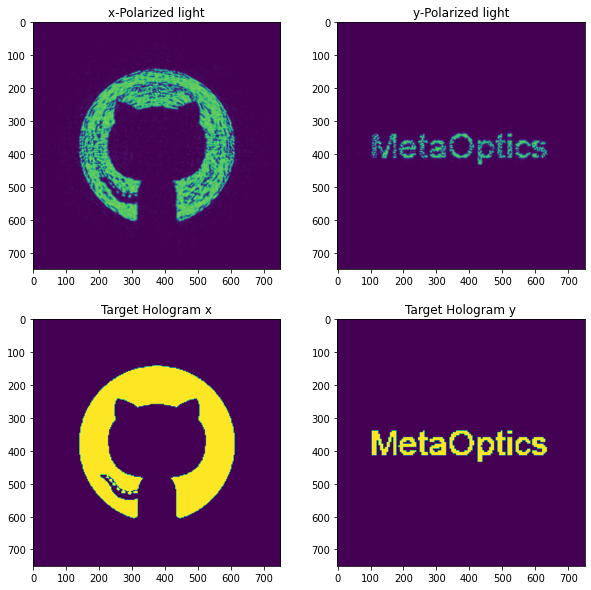

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  40 1.1103312969207764 0.7992062634984539
Training Log | (Step, time, loss):  41 1.0441045761108398 0.7946068703562594
Training Log | (Step, time, loss):  42 1.025259017944336 0.7899608196565308
Training Log | (Step, time, loss):  43 1.0244429111480713 0.7855716026632322
Training Log | (Step, time, loss):  44 1.0317082405090332 0.7812473139755057
Training Log | (Step, time, loss):  45 1.0294537544250488 0.7773232162542923
Training Log | (Step, time, loss):  46 1.0285005569458008 0.7739889137207713
Training Log | (Step, time, loss):  47 1.0282394886016846 0.7706756204641569
Training Log | (Step, time, loss):  48 1.02665376663208 0.7670521894005669
Training Log | (Step, time, loss):  49 1.0320138931274414 0.7643270036553953
Log Training at step: 50


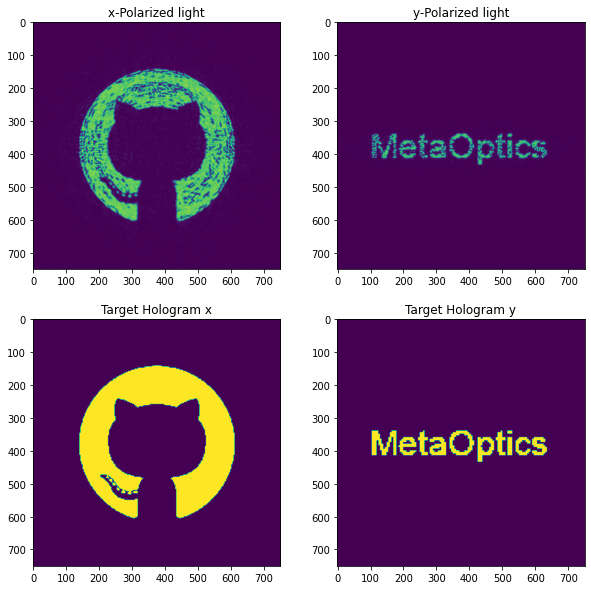

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  50 1.0469372272491455 0.7616098492738506
Training Log | (Step, time, loss):  51 1.0277752876281738 0.7588050141677241
Training Log | (Step, time, loss):  52 1.035080909729004 0.7560345055764675
Training Log | (Step, time, loss):  53 1.0433812141418457 0.7532815577818132
Training Log | (Step, time, loss):  54 1.0389823913574219 0.7509869171883115
Training Log | (Step, time, loss):  55 1.0246984958648682 0.7481010817767326
Training Log | (Step, time, loss):  56 1.022320032119751 0.7460031222752871
Training Log | (Step, time, loss):  57 1.024461269378662 0.7437625494741007
Training Log | (Step, time, loss):  58 1.0224955081939697 0.7417094945581378
Training Log | (Step, time, loss):  59 1.0243780612945557 0.7397169880941817
Log Training at step: 60


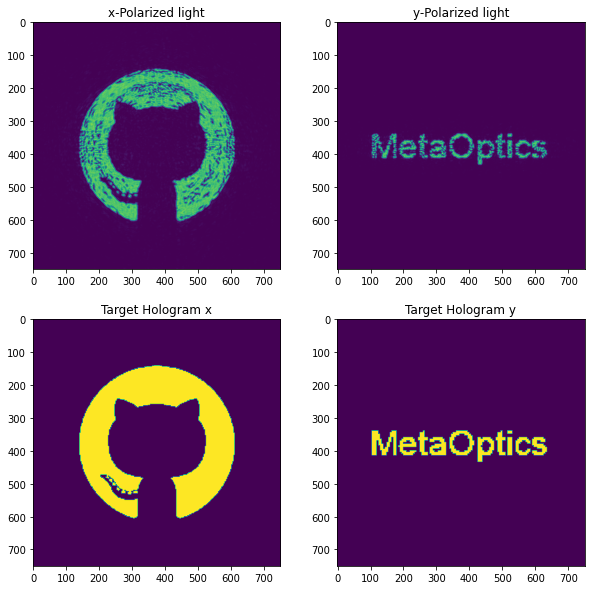

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  60 1.0276110172271729 0.7379882752250939
Training Log | (Step, time, loss):  61 1.015683889389038 0.7365861236134198
Training Log | (Step, time, loss):  62 1.0181684494018555 0.7350024378139429
Training Log | (Step, time, loss):  63 1.0320091247558594 0.733208591965305
Training Log | (Step, time, loss):  64 1.0313544273376465 0.7316379508541223
Training Log | (Step, time, loss):  65 1.0361838340759277 0.7298561165232261
Training Log | (Step, time, loss):  66 1.0363140106201172 0.7284087639114628
Training Log | (Step, time, loss):  67 1.0257928371429443 0.7268424794085412
Training Log | (Step, time, loss):  68 1.0211482048034668 0.725577896918073
Training Log | (Step, time, loss):  69 1.0233101844787598 0.7243342593546849
Log Training at step: 70


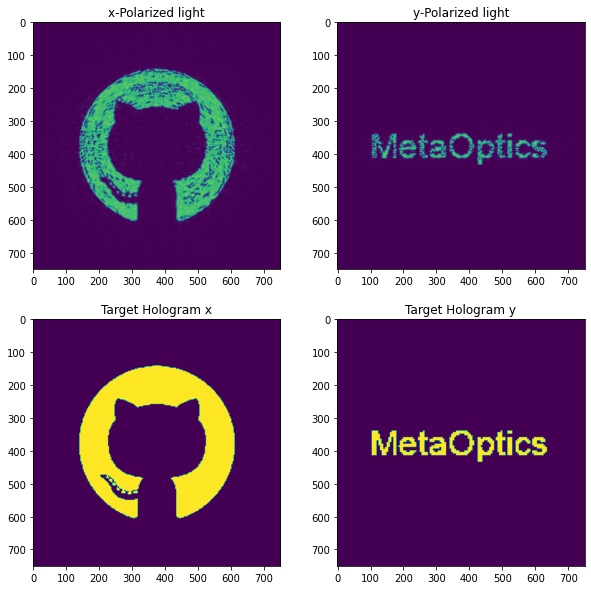

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  70 1.0441691875457764 0.7229140868537003
Training Log | (Step, time, loss):  71 1.0749876499176025 0.7219405582071396
Training Log | (Step, time, loss):  72 1.045741081237793 0.720457367325219
Training Log | (Step, time, loss):  73 1.0195269584655762 0.7195664889430172
Training Log | (Step, time, loss):  74 1.0224158763885498 0.7185878592494509
Training Log | (Step, time, loss):  75 1.019728660583496 0.7175502195568149
Training Log | (Step, time, loss):  76 1.0359156131744385 0.7165900898219195
Training Log | (Step, time, loss):  77 1.0327403545379639 0.7152116662309493
Training Log | (Step, time, loss):  78 1.0490391254425049 0.7143083128523355
Training Log | (Step, time, loss):  79 1.0485520362854004 0.7134059656488725
Log Training at step: 80


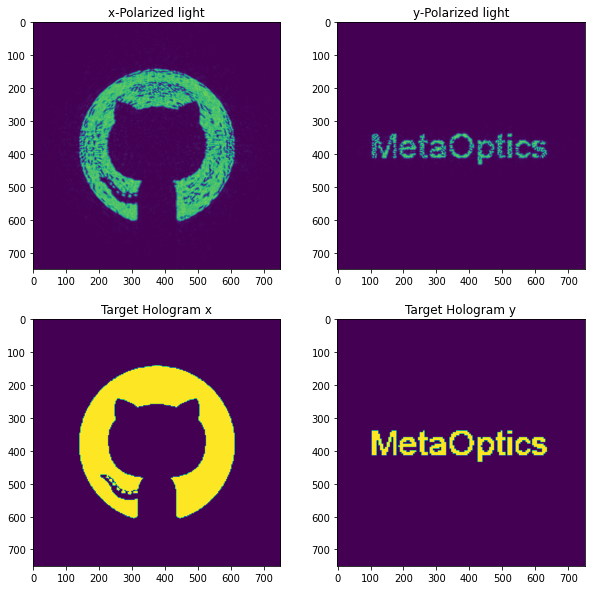

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  80 1.0624394416809082 0.7124237522499104
Training Log | (Step, time, loss):  81 1.0194578170776367 0.7118488849880036
Training Log | (Step, time, loss):  82 1.02353835105896 0.7109299065938778
Training Log | (Step, time, loss):  83 1.0287582874298096 0.7098672608344297
Training Log | (Step, time, loss):  84 1.0300042629241943 0.7088069404223236
Training Log | (Step, time, loss):  85 1.0270345211029053 0.7085882766352578
Training Log | (Step, time, loss):  86 1.0247242450714111 0.7075251973211233
Training Log | (Step, time, loss):  87 1.0345029830932617 0.7063798987249431
Training Log | (Step, time, loss):  88 1.0463273525238037 0.7057309770029129
Training Log | (Step, time, loss):  89 1.03938627243042 0.7049969118775458
Log Training at step: 90


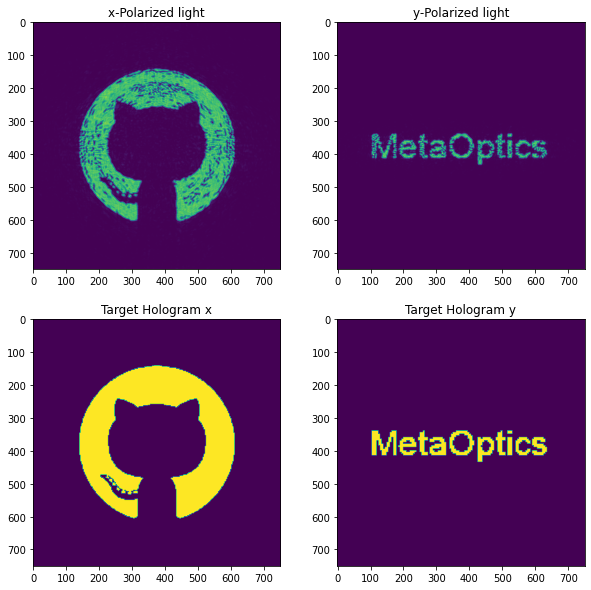

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss):  90 1.097120761871338 0.7043752907874457
Training Log | (Step, time, loss):  91 1.0371453762054443 0.7036708454071365
Training Log | (Step, time, loss):  92 1.0305602550506592 0.7034164944857175
Training Log | (Step, time, loss):  93 1.0273206233978271 0.7029225487699198
Training Log | (Step, time, loss):  94 1.0274720191955566 0.7019960074892873
Training Log | (Step, time, loss):  95 1.0316455364227295 0.7011224434236344
Training Log | (Step, time, loss):  96 1.0325546264648438 0.7009413369944317
Training Log | (Step, time, loss):  97 1.032186508178711 0.7000267811396678
Training Log | (Step, time, loss):  98 1.0333118438720703 0.6993436673159777
Training Log | (Step, time, loss):  99 1.033109426498413 0.6987395842597853
Log Training at step: 100


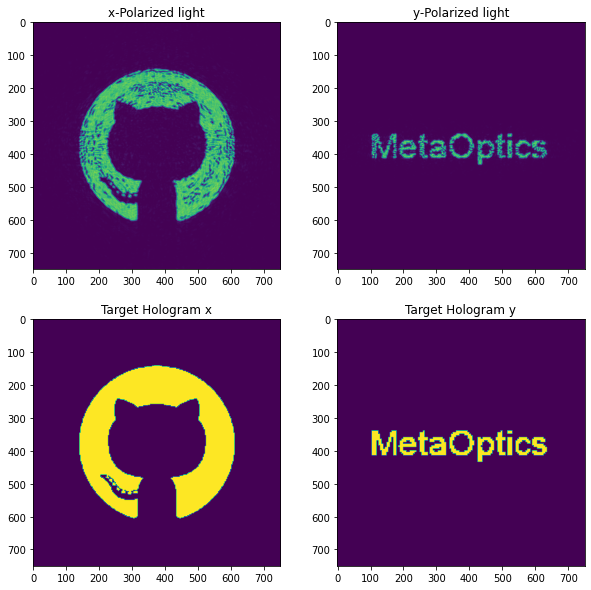

Save Checkpoint Model:

 Model Saved Succesfully 


 Model Saved Succesfully 



In [ ]:
### Define propagation parameters and initial lens
propagation_parameters = df_struct.prop_params(
    {
        "wavelength_set_m": [532e-9],
        "ms_samplesM": {"x": 512, "y": 512},
        "ms_dx_m": {"x": 1e-6, "y": 1e-6},
        "radius_m": None,
        "sensor_distance_m": 5e-3,
        "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_number": {"x": 750, "y": 750},
        "radial_symmetry": False,
        "diffractionEngine": "ASM_fourier",
        ###
        "automatic_upsample": False,
        "manual_upsample_factor": 1,
    }
  )
df_struct.print_full_settings(propagation_parameters)

### Load an image and then threshold it to binary
sensor_dim = propagation_parameters["sensor_pixel_number"]
image_x = df_images.get_grayscale_image("githublogo.png", sensor_dim, resize_method="pad")
image_y = df_images.get_grayscale_image("text2image_MetaOptics.png", sensor_dim, resize_method="crop")
image_target = np.transpose(np.concatenate((image_x, image_y), axis=-1), [2, 0, 1])

thresh = 40
image_target[np.where(image_target < thresh)] = 0.0
image_target[np.where(image_target >= 10)] = 1.0

### Create hologram optimizer
savepath = "examples/output/dual_polarization_hologram/"
saveAtEpoch = 10
pipeline = generate_hologram_metasurface(image_target, propagation_parameters, savepath, saveAtEpoch)
# pipeline.customLoad()

optimizer = tf.keras.optimizers.Adam(1e-1)
df_opt.run_pipeline_optimization(pipeline, optimizer, num_epochs=100, loss_fn=None, allow_gpu=True)
